<a href="https://colab.research.google.com/github/Abhinavk910/Regression/blob/master/House%20Price%20Prediction/Housing_Price_Using_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNet, Lasso, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error


import seaborn as sns
from scipy.stats import norm
from scipy import stats

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [0]:
from google.colab import files
upload = files.upload()

Saving test.csv to test (2).csv
Saving train.csv to train (2).csv


In [0]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv('test.csv')
df_train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [0]:
#Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

#Now drop the  'Id' colum
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

#data size 
print("\nThe train data size : {} ".format(df_train.shape)) 
print("The test data size  : {} ".format(df_test.shape))


The train data size : (1460, 80) 
The test data size  : (1459, 79) 


**Data Preprocessing**

In [0]:
# Function to plot two data
def plot(var, To_pred = 'SalePrice'):
  for i in range(len(var)):
    data = pd.concat([df_train[To_pred], df_train[var[i]]], axis=1)
    data.plot.scatter(x=var[i], y=To_pred, ylim=(0,df_train[To_pred].max()+df_train[To_pred].min()));


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


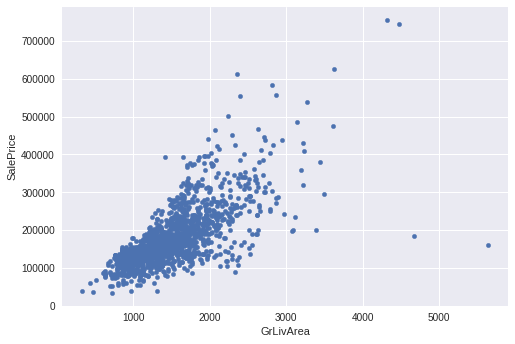

In [0]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

plot(['GrLivArea'])

In [0]:
#deleting outlier
df_train.drop(df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice']<300000)].index, inplace = True)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


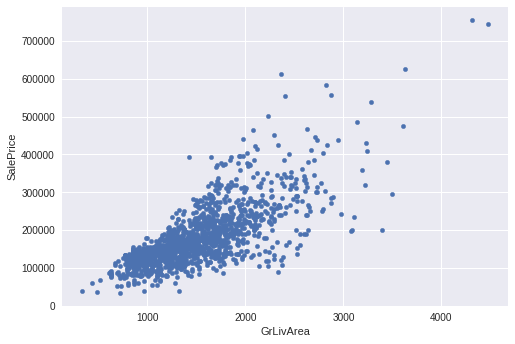

In [0]:
plot(['GrLivArea'])


SalePrice is the variable we need to predict. So let's do some analysis on this variable first.


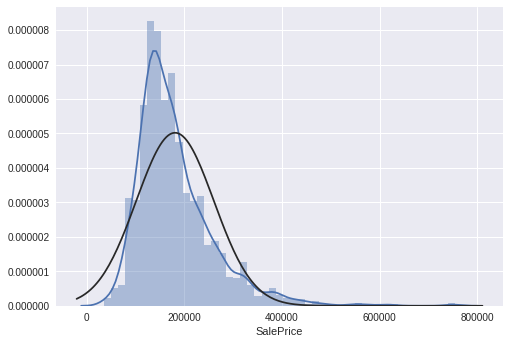

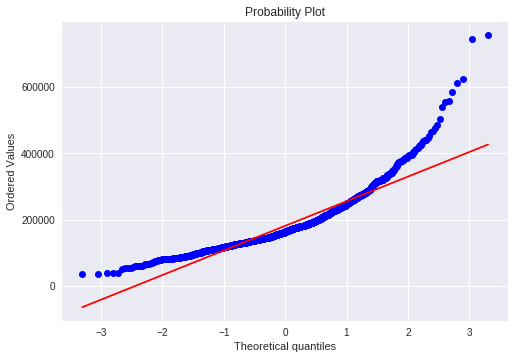

In [0]:
sns.distplot(df_train['SalePrice'],fit = norm)

#QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'],plot = plt)

In [0]:
# Log-transformation of the target variable
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

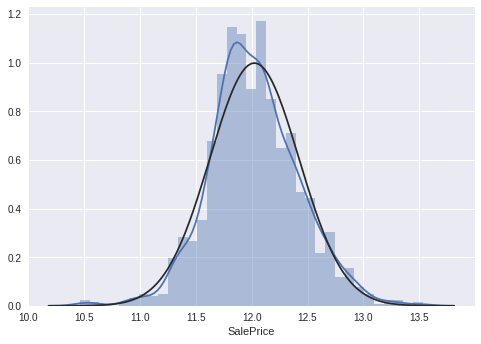

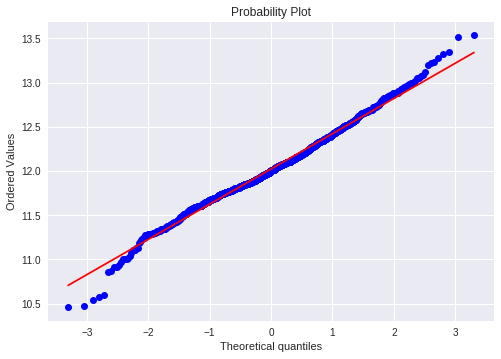

In [0]:
sns.distplot(df_train['SalePrice'],fit = norm)

#QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'],plot = plt)

# **Features** **engineerin**g

In [0]:
y_train = df_train.SalePrice.values
ndf_train = df_train.shape[0]
ndf_test = df_test.shape[0]

# Concatnation of test and train data
all_data = pd.concat([df_train, df_test]).reset_index(drop = True)
all_data.drop(['SalePrice'], axis = 1, inplace = True)
print('Size of All Data is :', all_data.shape)

Size of All Data is : (2917, 79)


In [0]:
# Checking Missing Value
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (round(all_data.isnull().sum()/all_data.isnull().count()*100, 2)).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', '%'])
missing_data.query('Total != 0')

,Total,%
PoolQC,2908,99.69
MiscFeature,2812,96.40
Alley,2719,93.21
Fence,2346,80.43
FireplaceQu,1420,48.68
LotFrontage,486,16.66
GarageFinish,159,5.45
GarageQual,159,5.45
GarageYrBlt,159,5.45
GarageCond,159,5.45


In [0]:
# Alley Nan mean its no alley access so filling NO
all_data.fillna(value={'Alley':'NO',
                      'MasVnrType':'NO',
                      'MasVnrArea':0,
                      'BsmtQual':'NO',
                      'BsmtCond' : 'NO',
                      'BsmtExposure' : 'NO',
                      'BsmtFinType1': 'NO',
                      'BsmtFinType2': 'NO',
                      'BsmtFinSF1' : 0,
                      'BsmtFinSF2' : 0,
                      'BsmtUnfSF' : 0,
                      'TotalBsmtSF':0,
                      'BsmtFullBath':0,
                      'BsmtHalfBath':0,
                      'FireplaceQu':'NO',
                      'GarageType': 'NO',                 
                      'GarageFinish':'NO',
                      'GarageQual' : 'NO',
                      'GarageCond' : 'NO',
                      'GarageCars' : 0,
                      'GarageArea' : 0,
                      'GarageYrBlt': 0,
#                       'Electrical' : 'NO',
                      'PoolQC' : 'NO',
                      'Fence' : 'NO',
                      'MiscFeature':'NO',
                      'LotFrontage' : 0,
                      'MSZoning' : all_data['MSZoning'].mode()[0],
                      'Functional': all_data['Functional'].mode()[0],
                      'Electrical': all_data['Electrical'].mode()[0],
                      'KitchenQual': all_data['KitchenQual'].mode()[0],
                      'Exterior1st': all_data['Exterior1st'].mode()[0],
                      'Exterior2nd': all_data['Exterior2nd'].mode()[0],
                      'SaleType': all_data['SaleType'].mode()[0],
                      'MSSubClass': all_data['MSSubClass'].mode()[0]
                     }, inplace = True)

In [0]:
all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [0]:
all_data = all_data.drop(['Utilities'], axis=1)

In [0]:
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (round(all_data.isnull().sum()/all_data.isnull().count()*100, 2)).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', '%'])
missing_data.query('Total != 0')

,Total,%


In [0]:
all_data = pd.get_dummies(all_data, drop_first=True)
print(all_data.shape)

(2917, 258)


In [0]:
df_train = all_data[:ndf_train]
df_test = all_data[ndf_train:]

#  Machine Learning Model

In [0]:
#Validation function
n_folds = 5

def rmse_cv(model, X = df_train.values):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    rmse= np.sqrt(-cross_val_score(model, X, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


In [0]:
classifier = []
name = []

model1 = Lasso(alpha =0.001,max_iter = 1000, random_state=1)
classifier.append(model1)
name.append('Lasso Regression')

model2 = ElasticNet(alpha=0.001, l1_ratio=.9,max_iter = 1000, random_state=1)
classifier.append(model2)
name.append('Elastic Net Regressor')

model3 = RandomForestRegressor(n_estimators = 200, random_state = 42, n_jobs = -1)
classifier.append(model3)
name.append('Random Forest Regressor')


In [0]:
dic = {}
for i in range(len(classifier)):
    score = rmse_cv(classifier[i])
    dic[name[i]]= [score.mean(), score.std()]

pd.DataFrame.from_dict(dic, orient = 'index')                                    #  0 - RMSE     1 - Std

,0,1
Lasso Regression,0.113720,0.005853
Elastic Net Regressor,0.113306,0.005821
Random Forest Regressor,0.138252,0.004383


In [0]:
def learning_curves(estimator,name,  X = df_train , y  = y_train, train_sizes = np.linspace(0.1, 1, 5), cv=5):
    train_sizes, train_scores, validation_scores = learning_curve(estimator, X, y, train_sizes = train_sizes, cv = cv, scoring = 'neg_mean_squared_error')
    
    train_scores_mean = np.sqrt(-train_scores).mean(axis = 1)
    validation_scores_mean = np.sqrt(-validation_scores).mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    plt.ylabel('RMSE', fontsize = 10)
    plt.xlabel('Training set size', fontsize = 10)
    title = 'LC for a ' + name
    plt.title(title, fontsize = 12, y = 1.03)
    plt.legend()
    return np.sqrt(-validation_scores[-1,:].mean())



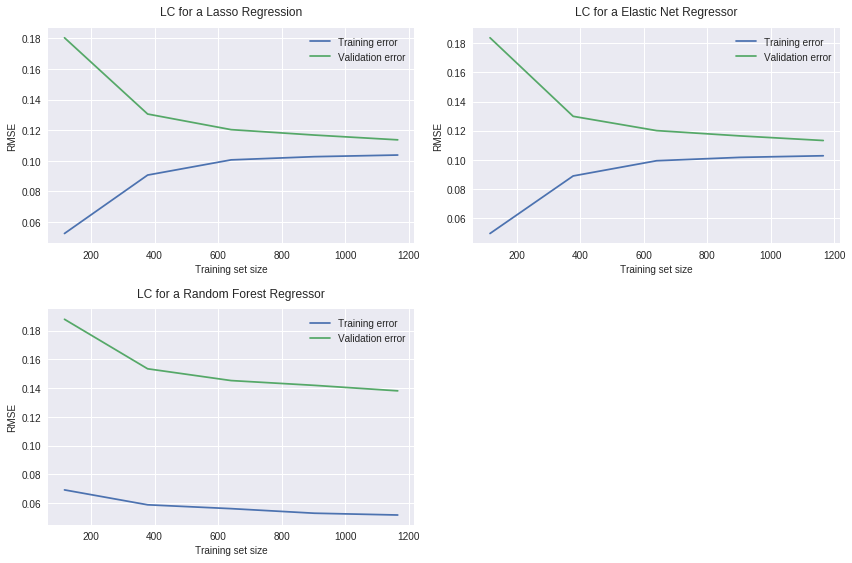

In [0]:
plt.figure(figsize = (12,8))

for i,j in enumerate(classifier):
  plt.subplot(2,2,i+1)
  learning_curves(j, name[i])
  plt.tight_layout()


**Lasso Regression**

0.11390058574553812

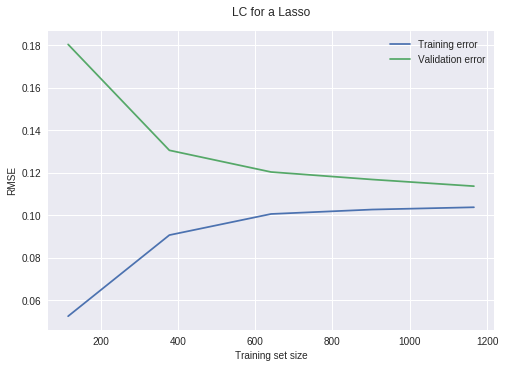

In [0]:
learning_curves(model1, 'Lasso')

 Look like variance is high

In [0]:
# Using smaller feature will help
df_train['SP'] = y_train

# calculating correlation matrix
corrmat = df_train.corr()

#sorting value according correlation 
best_feature_corr = corrmat['SP'].abs().sort_values(ascending = False)
df_train.drop(['SP'], axis = 1, inplace=True)

Learning Curve for Lasso with Feature


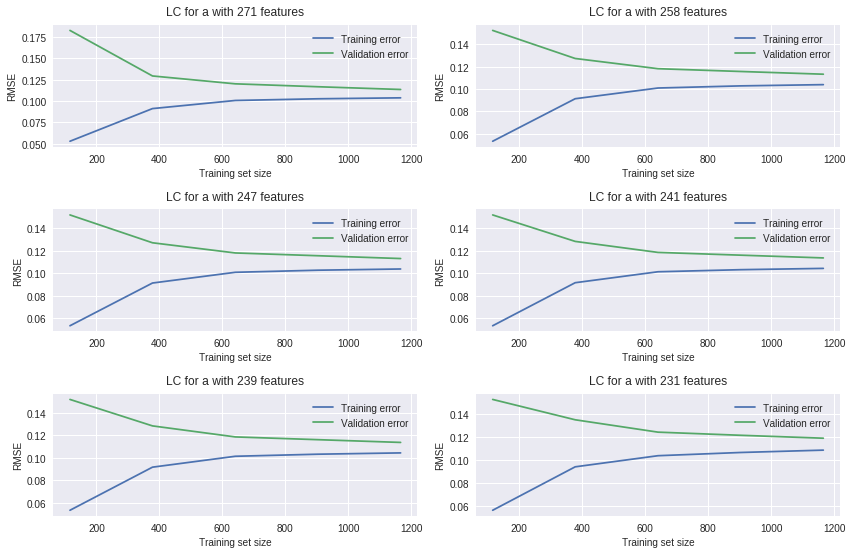

In [0]:

def grouplearningcurve(correlation_score, model):
    best_feature = best_feature_corr[best_feature_corr >correlation_score].index
    df_train_best_feature = df_train[best_feature[1:]]
    name = 'with ' + str(best_feature.shape[0]) + ' features'
    return best_feature.shape[0], learning_curves(model, name, X = df_train_best_feature,  y=y_train)


plt.figure(figsize = (12,10))
dic2 = {}
print('Learning Curve for Lasso with Feature')
for i, j in enumerate([0.02,0.025,0.03,0.033,0.035,0.04]):
    
    plt.subplot(4,2,i+1)
    no_of_feature, score = grouplearningcurve(j, model1)
    dic2[no_of_feature] = score
    plt.tight_layout()
    

Text(0.5, 1.0, 'Graph Between RSME and Threshold of Correlation Matrix score')

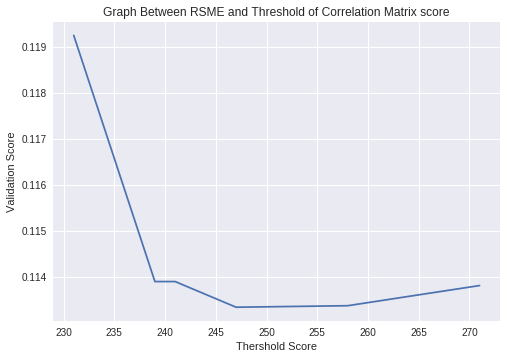

In [0]:
plt.plot(pd.DataFrame.from_dict(dic2, orient = 'index'))
plt.xlabel('Thershold Score')
plt.ylabel('Validation Score')
plt.title('Graph Between RSME and Threshold of Correlation Matrix score')

In [0]:
best_feature = best_feature_corr[best_feature_corr >0.03].index
df_train_best_feature = df_train[best_feature[1:]]

In [0]:
lasso2 = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006,], 
                max_iter = 50000, cv = 5)
lasso2.fit(df_train_best_feature, y_train)
alpha = lasso2.alpha_

print("Best alpha :", alpha)

Best alpha : 0.0006


In [0]:
score = rmse_cv(lasso2, X = df_train_best_feature)
print('RSME -', score.mean())
print('with std - ', score.std())

RSME - 0.1121313393490532
with std -  0.006454807182972887


####  Checking Elastic Net

0.11348659882115505

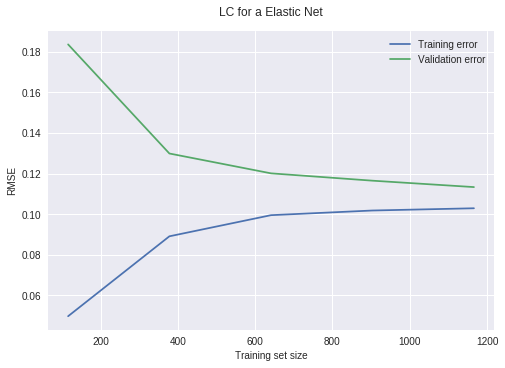

In [0]:
learning_curves(model2 , 'Elastic Net')

Learning Curve for Elastic Net with Feature


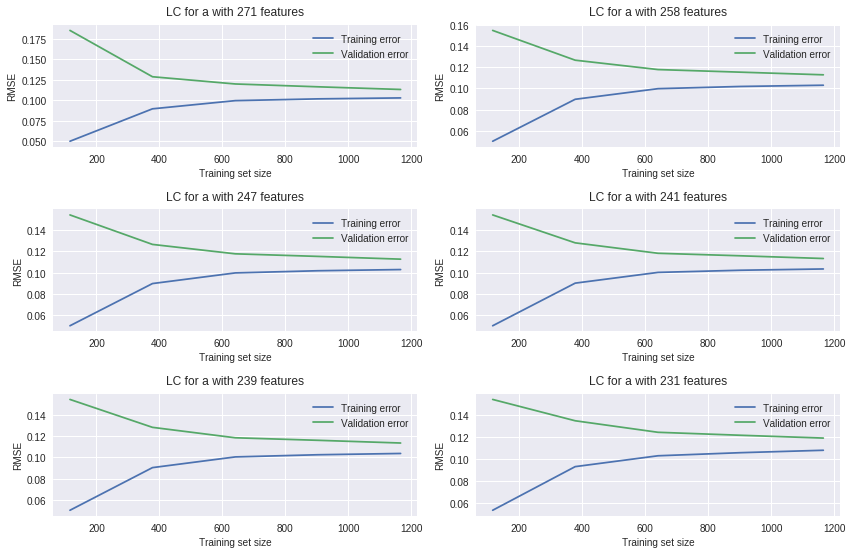

In [0]:
plt.figure(figsize = (12,10))
dic3 = {}
print('Learning Curve for Elastic Net with Feature')
for i, j in enumerate([0.02,0.025,0.03,0.033,0.035,0.04]):
    plt.subplot(4,2,i+1)
    no_of_feature, score = grouplearningcurve(j, model2)
    dic3[no_of_feature] = score
    plt.tight_layout()

Text(0.5, 1.0, 'Graph Between RSME and Threshold of Correlation Matrix score')

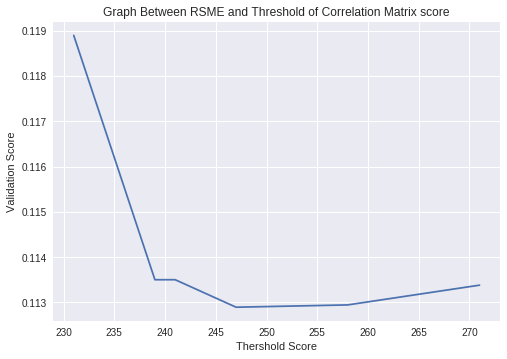

In [0]:
plt.plot(pd.DataFrame.from_dict(dic3, orient = 'index'))
plt.xlabel('Thershold Score')
plt.ylabel('Validation Score')
plt.title('Graph Between RSME and Threshold of Correlation Matrix score')

In [0]:
best_feature = best_feature_corr[best_feature_corr >0.03].index
df_train_best_feature = df_train[best_feature[1:]]

In [0]:
elasticNet2 = ElasticNetCV(l1_ratio = [0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003], 
                          max_iter = 50000, cv = 10)
elasticNet2.fit(df_train_best_feature, y_train)
alpha = elasticNet2.alpha_
ratio = elasticNet2.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Best l1_ratio : 1.0
Best alpha : 0.0003


In [0]:
elasticNet3 = ElasticNet(alpha =0.0003, l1_ratio = 1,  random_state=1)
score = rmse_cv(elasticNet3, X=df_train_best_feature)
print('RSME -', score.mean())
print('with std - ', score.std())

RSME - 0.11228892212787381
with std -  0.006619925408417409


Finally Lasso Worked Well

In [0]:
lasso2.fit(df_train_best_feature, y_train)


LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006], copy_X=True,
    cv=5, eps=0.001, fit_intercept=True, max_iter=50000, n_alphas=100,
    n_jobs=None, normalize=False, positive=False, precompute='auto',
    random_state=None, selection='cyclic', tol=0.0001, verbose=False)

In [0]:
best_feature = best_feature_corr[best_feature_corr >0.03].index
df_test_best_feature = df_test[best_feature[1:]]
df_test_best_feature.shape

(1459, 212)

In [0]:
y_pred = lasso2.predict(df_test_best_feature)

In [0]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = np.expm1(predictions)
sub.to_csv('submission.csv',index=False)

In [0]:
from google.colab import files

sub.to_csv('submission.csv', index = False)
files.download('submission.csv')

In [0]:

df_train.shape

df_train_best_feature.shape[1]

212

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint


In [0]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(150, kernel_initializer='normal',input_dim = df_train_best_feature.shape[1], activation='relu'))
NN_model.add(Dropout(0.2))

# The Hidden Layers :
NN_model.add(Dense(150, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.3))
NN_model.add(Dense(150, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.1))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 150)               31950     
_________________________________________________________________
dropout_4 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_5 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_6 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 151       
Total para

In [0]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]


NN_model.fit(df_train_best_feature, y_train, batch_size= 32, epochs= 500,
                 validation_split = 0.2, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 1166 samples, validate on 292 samples
Epoch 1/500
1166/1166 [==============================] - 3s 3ms/step - loss: 15.8975 - mean_absolute_error: 15.8975 - val_loss: 6.2833 - val_mean_absolute_error: 6.2833

Epoch 00001: val_loss improved from inf to 6.28326, saving model to Weights-001--6.28326.hdf5
Epoch 2/500
1166/1166 [==============================] - 0s 160us/step - loss: 5.8191 - mean_absolute_error: 5.8191 - val_loss: 4.4613 - val_mean_absolute_error: 4.4613

Epoch 00002: val_loss improved from 6.28326 to 4.46128, saving model to Weights-002--4.46128.hdf5
Epoch 3/500
1166/1166 [==============================] - 0s 155us/step - loss: 3.8502 - mean_absolute_error: 3.8502 - val_loss: 7.2473 - val_mean_absolute_error: 7.2473

Epoch 00003: val_loss did not improve from 4.46128
Epoch 4/500
1166/1166 [==============================] - 0s 173us/step - loss: 3.7217 - mean_absolute_error: 3.7217 - val_loss: 2.6425 - val_mean_absolu

In [0]:
wights_file = 'Weights-494--2.20831.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])


In [0]:
predictions = NN_model.predict(df_test_best_feature)

In [0]:
predictions


array([[9.700859 ],
       [9.8442135],
       [9.937483 ],
       ...,
       [9.9646435],
       [9.605899 ],
       [9.965819 ]], dtype=float32)